# Making models with Bagpipes

This example will show you how to make a model galaxy with Bagpipes and how to plot the model observables associated with it. You'll need to understand the syntax used here before moving on to fitting observational data. For further information see the [model galaxy](http://bagpipes.readthedocs.io/en/latest/model_galaxies.html) page of the documentation.


## Defining filter curves

First things first, if you want to generate model photometry you'll need to tell bagpipes where to find the filter curves. To do this, construct a list containing paths from the current directory to the locations the filter curve files are stored. 

The filter curve files should start with a column of wavelengths in Angstroms, followed by a column of transmission values.

In [1]:
import bagpipes as pipes
import numpy as np

uvista_filt_list = ["uvista/CFHT_u.txt",
                    "uvista/CFHT_g.txt",
                    "uvista/CFHT_r.txt",
                    "uvista/CFHT_i+i2.txt",
                    "uvista/CFHT_z.txt",
                    "uvista/subaru_z",
                    "uvista/VISTA_Y.txt",
                    "uvista/VISTA_J.txt",
                    "uvista/VISTA_H.txt",
                    "uvista/VISTA_Ks.txt",
                    "uvista/IRAC1",
                    "uvista/IRAC2"]

## The model components dictionary

Instructions about what kind of model to make are passed to the code via the model components dictionary. Each "component" is a sub-dictionary containing information about either the star-formation history, the dust model or the nebular emission model. A number of global properties can also be specified directly within model components. The only required global property is redshift.

An unlimited number of components can be specified to define the star-formation history, however normally one is enough. Options include bursts and tau-models as well as more complicated parameterisations, such as a double-power-law. A simple tau model with Calzetti dust can be set up as follows.

In [2]:
exp = {}                          # Tau-model star-formation history component
exp["age"] = 3.                   # Gyr
exp["tau"] = 0.75                 # Gyr
exp["massformed"] = 9.            # log_10(M*/M_solar)
exp["metallicity"] = 0.5          # Z/Z_oldsolar

dust = {}                         # Dust component
dust["type"] = "Calzetti"         # Define the shape of the attenuation curve
dust["Av"] = 0.2                  # mag

model_comp = {}                   # The model components dictionary
model_comp["redshift"] = 1.0      # Observed redshift  
model_comp["exponential"] = exp   
model_comp["dust"] = dust

## Making the model

We're now ready to make our model galaxy. The command is:

In [3]:
model = pipes.model_galaxy(model_comp, filt_list=uvista_filt_list)

We can generate a quick plot to see what the model spectrum and star-formation history look like with:

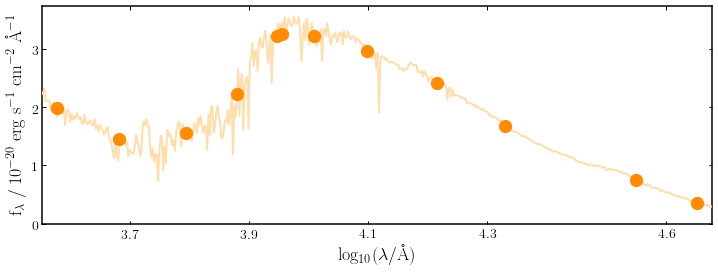

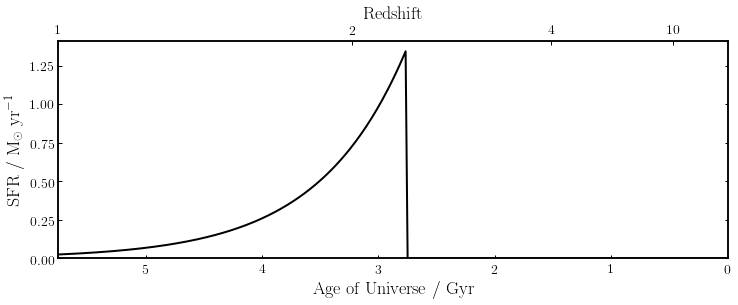

In [4]:
fig = model.plot()
fig = model.sfh.plot()

## Model spectroscopy

We can generate an output spectroscopic observation by passing an array of wavelengths in Angstroms to model_galaxy as the spec_wavs keyword argument:

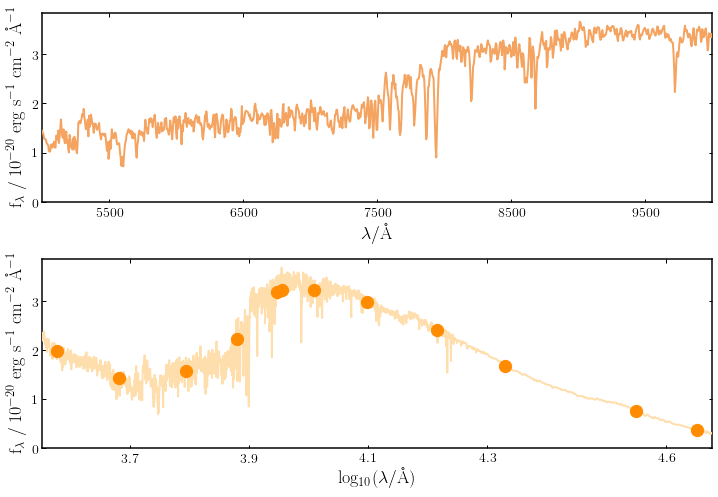

In [5]:
model = pipes.model_galaxy(model_comp, filt_list=uvista_filt_list, spec_wavs=np.arange(5000., 10000., 5.))

fig = model.plot()

## Updating model parameters

The parameters of a model can be updated to change the output model observables. This  is computationally much faster than making a new model, and is achieved using the update method. We can change numerical values and pass the updated model_comp to the update method to change the model spectrum.

The update method does not support adding or removing components, e.g. adding nebular emission, or changing non-numerical values e.g. the type of dust.

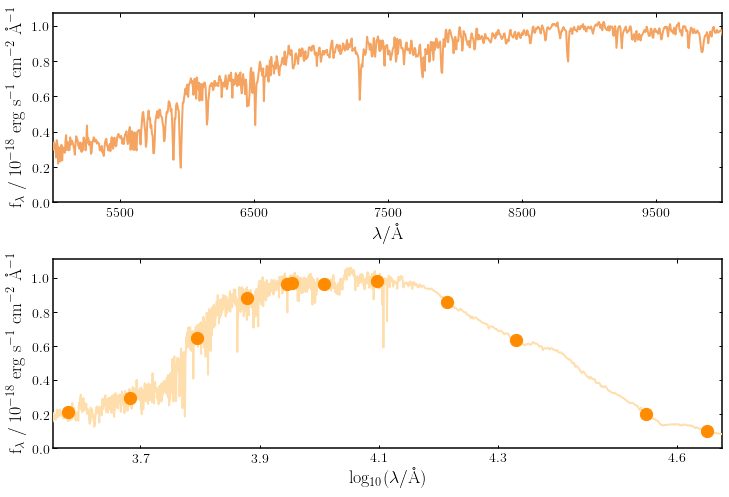

In [6]:
exp["massformed"] = 10.           
exp["metallicity"] = 1.0
dust["Av"] = 1.0
model_comp["redshift"] = 0.5

model.update(model_comp)
fig = model.plot()

## Adding complexity to the model - nebular emission

Now we can make the model a little more interesting. Let's add nebular emission and velocity dispersion.

Note that because we're adding a new component we need to re-generate a new model rather than using the update method.

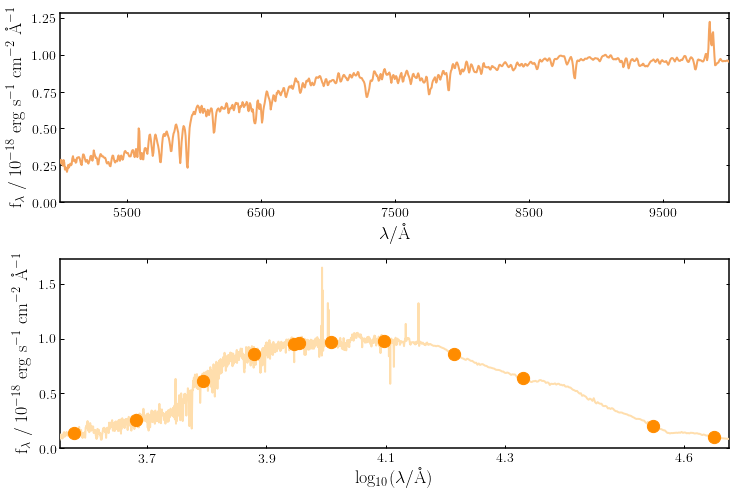

In [7]:
nebular = {}                      # Nebular emission component
nebular["logU"] = -3.             # log_10(ionization parameter)

dust["eta"] = 3.                  # Extra dust for young stars: multiplies Av

model_comp["t_bc"] = 0.01         # Lifetime of birth clouds (Gyr)
model_comp["veldisp"] = 200.      # km/s
model_comp["nebular"] = nebular

model = pipes.model_galaxy(model_comp, filt_list=uvista_filt_list, spec_wavs=np.arange(5000., 10000., 5.))

fig = model.plot()

## Adding complexity to the model - star-formation histories

Let's try out a more interesting star-formation history. We'll try a double-power-law and some bursts. Multiple components of the same type can be distinguished by numbering each component:

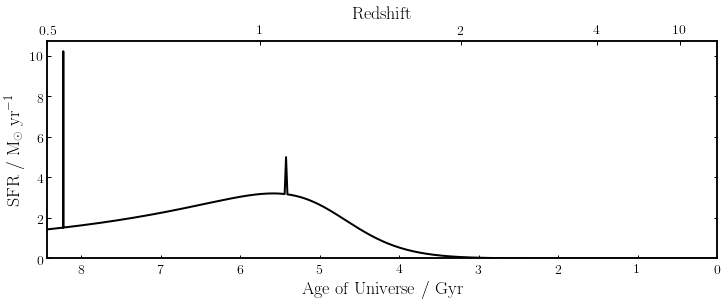

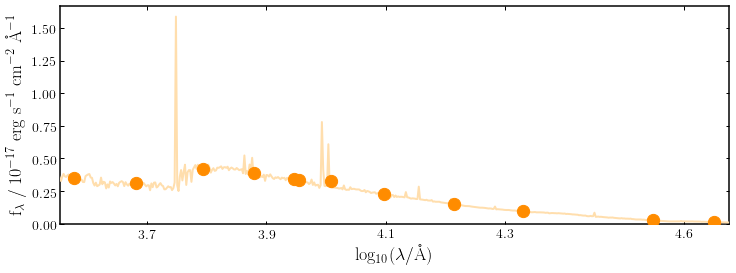

In [8]:
dust = {}                         
dust["type"] = "Calzetti"         
dust["Av"] = 0.2                  
dust["eta"] = 3.                  

nebular = {}                      
nebular["logU"] = -3.             

dblplaw = {}
dblplaw["tau"] = 5.            # Time of peak (Gyr)
dblplaw["alpha"] = 2.5         # falling slope power-law index
dblplaw["beta"] = 10.          # rising slope power-law index
dblplaw["massformed"] = 10.
dblplaw["metallicity"] = 0.5

burst1 = {}
burst1["age"] = 0.2
burst1["massformed"] = 7.
burst1["metallicity"] = 1.

burst2 = {}
burst2["age"] = 3.
burst2["massformed"] = 7.5
burst2["metallicity"] = 0.2

model_comp = {}                   
model_comp["redshift"] = 0.5
model_comp["t_bc"] = 0.01         
model_comp["veldisp"] = 200. 
model_comp["burst1"] = burst1
model_comp["burst2"] = burst2
model_comp["dblplaw"] = dblplaw
model_comp["dust"] = dust
model_comp["nebular"] = nebular

model = pipes.model_galaxy(model_comp, filt_list=uvista_filt_list)

sfh = model.sfh.plot()
fig = model.plot()

Finally, let's try out a custom star-formation history. You can pass a numpy array containing a column of ages in years and a column of star-formation rates in Solar masses per year:

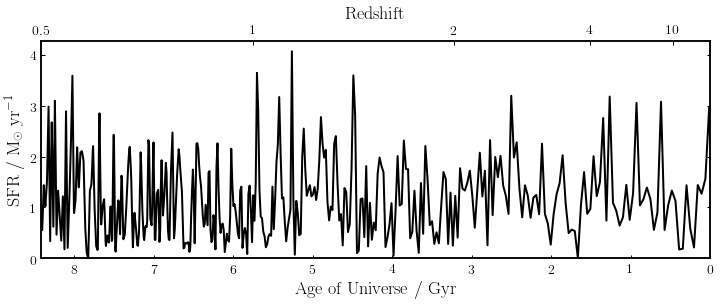

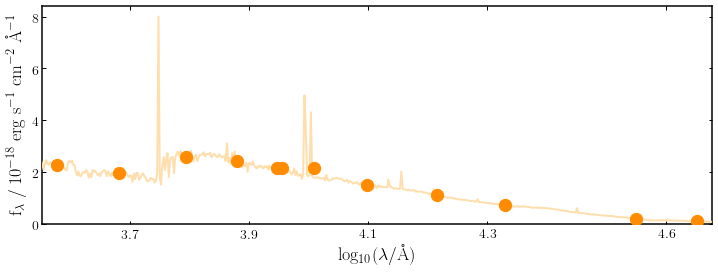

In [9]:
dust = {}                         
dust["type"] = "Calzetti"         
dust["Av"] = 0.2                  
dust["eta"] = 3.                  

nebular = {}                      
nebular["logU"] = -3.             

sfh = np.zeros((500, 2))
sfh[:, 0] = np.arange(0., 10., 0.02)*10**9
sfh[:, 1] = np.abs(np.random.randn(500))

custom = {}
custom["history"] = sfh
custom["massformed"] = 10.
custom["metallicity"] = 1.

model_comp = {}                   
model_comp["redshift"] = 0.5
model_comp["t_bc"] = 0.01         
model_comp["veldisp"] = 200. 
model_comp["custom"] = custom
model_comp["dust"] = dust
model_comp["nebular"] = nebular

model = pipes.model_galaxy(model_comp, filt_list=uvista_filt_list)

sfh = model.sfh.plot()
fig = model.plot()